In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

%matplotlib inline

# #1

In [5]:
path = 'smsspamcollection/SMSSpamCollection'

messages = pd.read_csv(path, sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Загрузили, посмотрели. Смотрим на классы

In [6]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


Выборка очевидно несбалансирована по классам (~6:1). Соответственно, dummy-classifier, всегда присваивающий ярлык "ham", будет иметь accuracy ~86%, а confusion matrix будет выглядеть вот так:

In [7]:
d = {'clf_ham': pd.Series([4825, 747], index=['ham', 'spam']),
    'clf_spam': pd.Series([0, 0], index=['ham', 'spam'])}
pd.DataFrame(d)

,clf_ham,clf_spam
ham,4825,0
spam,747,0


Для задачи определения спама классификатор, который никогда не определяет спам, абсолютно бесполезен просто по определению.

Соотношение 6:1 - вот и отлично, разделим ham на шесть непересекающихся выборок, обучим классификатор с каждым

In [123]:
# токенизируем, лемматизируем, стеммим, всё вот это запихиваем в один датафрейм
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer


def tokenize(text):
    text = text.lower()
    return word_tokenize(text)


msg_tok = messages['message'].map(tokenize)


lm = WordNetLemmatizer()
st = LancasterStemmer()


def lemmatize(arr):
    return list(map(lm.lemmatize, arr))


def stem(arr):
    return list(map(st.stem, arr))

msg_df = pd.DataFrame({'tokenized': msg_tok, 
                    'lemmatized': msg_tok.map(lemmatize), 'stemmatized': msg_tok.map(stem), 
                    'label': messages['label']})

In [124]:
msg_df.head()

,label,lemmatized,stemmatized,tokenized
0,ham,"[go, until, jurong, point, ,, crazy.., availab...","[go, until, jurong, point, ,, crazy.., avail, ...","[go, until, jurong, point, ,, crazy.., availab..."
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., jok, wif, u, on, ...]","[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[fre, entry, in, 2, a, wkly, comp, to, win, fa...","[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,"[u, dun, say, so, early, hor, ..., u, c, alrea...","[u, dun, say, so, ear, hor, ..., u, c, already...","[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,ham,"[nah, i, do, n't, think, he, go, to, usf, ,, h...","[nah, i, do, n't, think, he, goe, to, usf, ,, ...","[nah, i, do, n't, think, he, goes, to, usf, ,,..."


Но в таком виде ни один векторайзер ничего не примет (как оказалось), поэтому попробуем сджойнить листы

In [125]:
for col in msg_df.columns[1:]:
    msg_df[col] = msg_df[col].map(lambda x: ' '.join(x))
msg_df.head(2)

,label,lemmatized,stemmatized,tokenized
0,ham,"go until jurong point , crazy.. available only...","go until jurong point , crazy.. avail on in bu...","go until jurong point , crazy.. available only..."
1,ham,ok lar ... joking wif u oni ...,ok lar ... jok wif u on ...,ok lar ... joking wif u oni ...


Окей.

In [185]:
# настраиваем gridsearch
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import TreebankWordTokenizer
parameters = {'vect__stop_words': [None, 'english'],
              'vect__min_df': [1, 3],
              'vect__max_df': [1.0, 0.6], 
              'vect__tokenizer': [None, TreebankWordTokenizer().tokenize]}

In [186]:
# теперь будем это всё делить.
# и запускать.

ham = msg_df.loc[msg_df['label']=='ham']
spam = msg_df.loc[msg_df['label']=='spam']


gs_stats = {}
len_ham_sample = len(ham)//6

# 0 колонка - это label, его не перебираем
for column in msg_df.columns[1:]:
    gs_stats[column] = {'CV': [], 'TI': []}
    for i in range(6):
        # делим на шесть равных выборок (игнорируем в итоге не больше пяти наблюдений)
        ham_sample = ham[i*len_ham_sample:i*len_ham_sample+len_ham_sample]
        # очень плохо, что они не перемешаны, ноо
        shard = pd.concat([spam, ham_sample])
        X = shard[column]
        y = shard['label']
        # строим пайплайны
        CV_clf = Pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()), 
                           ('clf', MultinomialNB()),])
        TI_clf = Pipeline([('vect', TfidfVectorizer()),
                           ('tfidf', TfidfTransformer()), 
                           ('clf', MultinomialNB()),])
        gs_cv = GridSearchCV(CV_clf, parameters)
        gs_ti = GridSearchCV(TI_clf, parameters)
        gs_cv = gs_cv.fit(X, y)
        gs_ti = gs_ti.fit(X, y)
        gs_stats[column]['CV'].append(gs_cv)
        gs_stats[column]['TI'].append(gs_ti)

In [191]:
# посмотреть что вообще что-то получилось
gs_stats['lemmatized']['CV'][0].cv_results_['mean_test_score']

array([ 0.95938104,  0.95551257,  0.94906512,  0.94519665,  0.94970986,
        0.95228885,  0.95035461,  0.94132818,  0.95938104,  0.95551257,
        0.94906512,  0.94519665,  0.94970986,  0.95228885,  0.95035461,
        0.94132818])

Итак, у нас есть все классификаторы для всех сочетаний всего со всем. Теперь усреднить результаты для разных шардов одной выборки

In [192]:
# усредняем и округляем
for column in gs_stats:
    means_CV = [gs_stats[column]['CV'][i].cv_results_['mean_test_score'] for i in range(6)]
    gs_stats[column]['CV_means'] = list(map(lambda x: round(x, 3), np.mean(np.array(means_CV), axis=0)))
    means_TI = [gs_stats[column]['TI'][i].cv_results_['mean_test_score'] for i in range(6)]
    gs_stats[column]['TI_means'] = list(map(lambda x: round(x, 3), np.mean(np.array(means_TI), axis=0)))

Окей, теперь есть что-то, на что хотя бы можно попробовать посмотреть.

In [193]:
# возьмём параметры из гридсёрча в том порядке, в котором они применялись (и в котором идут результаты)
# заменим огромный кусман трибанковского метода чем-нибудь покороче
params = gs_stats['lemmatized']['CV'][0].cv_results_['params']
params = list(map(lambda x: list(x.values()), params))
params = [list(map(lambda x: 'yes' if x.__class__ not in [int, str, float, None.__class__] else x, par)) for par in params]
params[1:3]

[['yes', 1, 1.0, None], [None, 1, 1.0, 'english']]

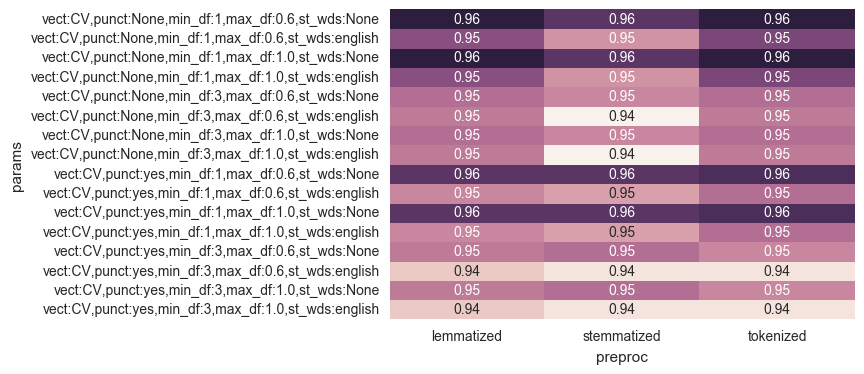

In [194]:
# порядок понят, графицируем. Только клеток очень много, поэтому сделаю два графика, по одному на векторайзер
cv_data = []
ti_data = []
for column in gs_stats:
    params_line = 'vect:{},punct:{},min_df:{},max_df:{},st_wds:{}'
    cv_data += [[gs_stats[column]['CV_means'][i], params_line.format('CV', *params[i]), column] for i in range(len(params))]
    ti_data += [[gs_stats[column]['TI_means'][i], params_line.format('TI', *params[i]), column] for i in range(len(params))]

# CountVectorizer
cv_data = pd.DataFrame(cv_data, columns=['mean', 'params', 'preproc']).fillna("None")
cv_data = cv_data.pivot('params', 'preproc', 'mean')
sns.heatmap(cv_data, annot=True, cbar=False);

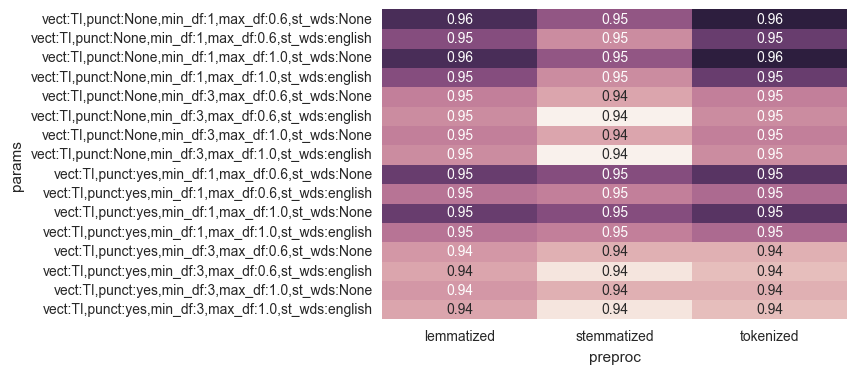

In [195]:
# TfidfVectorizer
ti_data = pd.DataFrame(ti_data, columns=['mean', 'params', 'preproc']).fillna("None")
ti_data = ti_data.pivot('params', 'preproc', 'mean')
sns.heatmap(ti_data, annot=True, cbar=False);

Итак, как мы видим, воздействие векторизации с помощью CountVectorizer было немного более благотворным, чем векторизации с помощью TfidfVectorizer (в целом первая курта чууть-чуть темнее), причём TfidfVectorizer даёт на не лемматизированной/стемматизированной выборке лучшие (до 1%) результаты, чем на лемматизированной/стемматизированной (с CountVectorizer такого не происходит). Стемматизация даёт минус к продуктивности (до 2%) всем и всегда даже относительно простой токенизации, а наличие знаков препинания загадочным образом улучшает результаты на стемматизированной выборке, но ухудшает на темматизированной или выборке без обработки (всё до 1%). Ещё лучше не ограничивать минимальную df (до 1% хуже при ограничении min_df=3) и не удалять стоп-слова (до -0.5%). max_df, кажется, не играет никакой роли (ну или надо выбирать значения поменьше).

Итог: стемматизация - плохо, ограничивать min_df при векторизации тоже не очень. Лучшая модель максимально ленивая - дефолтные настройки TfidfVectorizer на токенизированной выборке без знаков препинания.

# #2

2(+2). Сравнить результаты байесовского классификатора, решающего дерева и RandomForest. Помимо стандартных метрик оценки качества модели, необходимо построить learning curve, ROC-curve, classification report и интерпретировать эти результаты.

То есть по всем вот этим параметрам ещё раз проходить?

In [ ]:
# насколько я помню, деревья нормально справляются с несбалансированной выборкой, так что просто
from sklearn.tree import DecisionTreeClassifier

tree_stats = {}
# вспоминаем где лежат данные вообще
for column in msg_df.columns[1:]:
    tree_stats[column] = {'CV': [], 'TI': []}
    for i in range(6):
        X = msg_df[column]
        y = msg_df['label']
        CV_clf = Pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer()), 
                           ('clf', DecisionTreeClassifier()),])
        TI_clf = Pipeline([('vect', TfidfVectorizer()),
                           ('tfidf', TfidfTransformer()), 
                           ('clf', DecisionTreeClassifier()),])
        gs_cv = GridSearchCV(CV_clf, parameters)
        gs_ti = GridSearchCV(TI_clf, parameters)
        gs_cv = gs_cv.fit(X, y)
        gs_ti = gs_ti.fit(X, y)
        tree_stats[column]['CV'].append(gs_cv)
        tree_stats[column]['TI'].append(gs_ti)

In [ ]:
cv_data = []
ti_data = []
for column in gs_stats:
    params_line = 'vect:{},punct:{},min_df:{},max_df:{},st_wds:{}'
    cv_data += [[tree_stats[column]['CV'][i].cv_results_['mean_test_score'], params_line.format('CV', *params[i]), column] for i in range(len(params))]
    ti_data += [[tree_stats[column]['TI'][i].cv_results_['mean_test_score'], params_line.format('TI', *params[i]), column] for i in range(len(params))]

# CountVectorizer
cv_data = pd.DataFrame(cv_data, columns=['mean', 'params', 'preproc']).fillna("None")
cv_data = cv_data.pivot('params', 'preproc', 'mean')
sns.heatmap(cv_data, annot=True, cbar=False);

In [ ]:
from sklearn.ensemble import RandomForestClassifier



3(+2). А что, если в качестве предикторов брать не количество вхождений слов, а конструировать специальные признаки? Прежде всего, необходимо разделить таблицу на training set и test set в соотношении 80:20, test set не открывать до этапа оценки модели. С помощью pandas проверить, отличаются ли перечисленные ниже параметры (иможно придумать другие) для разных классов (spam/ham), и собрать матрицу признаков для обучения. Примеры признаков: длина сообщения, количество букв в ВЕРХНЕМ РЕГИСТРЕ, восклицательных знаков, цифр, запятых, каких-то конкретных слов (для этого можно построить частотный словарь по сообщениям каждого класса). Прокомментировать свой выбор. Векторизовать документы и построить классификатор. Оценить модель на проверочной выборке.

http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [ ]:
messages['length'] = messages['message'].map(lambda text: len(text))

In [ ]:
# print(messages.head())

# tokens = [word_tokenize(msg) for msg in messages]


def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

# messages.message.head().apply(tokenize)
# messages.message = messages.message.apply(tokenize)

# print(messages.head())

In [ ]:
bow = CountVectorizer()
bow.fit_transform(messages['message'])
# print(bow.vocabulary_)

# m = messages['message'][3]
# print([m])
# bowed_m = bow.transform([m])
# print(bowed_m.shape)
# print(bow.get_feature_names()[1054])

bowed_messages = bow.transform(messages['message'])

In [ ]:
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, messages['label'])

In [ ]:
# naive_model.predict()

# msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)
# print(len(msg_train), len(msg_test))
cv_results = cross_val_score(naive_model, bowed_messages, messages['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

In [ ]:
# pipeline = Pipeline([
#     ('bow', CountVectorizer(analyzer=tokenize)),
#     ('classifier', MultinomialNB()),
# ])
#
# cv_results = cross_val_score(pipeline,
#                              msg_train,
#                              label_train,
#                              cv=10,
#                              scoring='accuracy',
#                              )
# print(cv_results.mean(), cv_results.std())